# 2D GP feature extraction do-over + final CatBoost classifier
Comment 31/01/26: This is the notebook providing my final result. With the csv files in the input-data directory my results can quickly be reproduced without going through all feature extraction steps (if so desired). <br>
The notebook is structured as follows:

- A 2D GP fit function, adapted from Avocado (K. Boone 2019), is defined and used on raw light curves
- The resulting interpolated light curves are saved locally
- An adaptation of the extract_raw_features function from Avocado (K. Boone 2019) is used on each object
- A set of training features is constructed
- A CatBoost classifier is trained and used with experimental prediction probability thresholds to optimize performance
- Feature importances are investigated<br>

NOTE: I am naming variables quite confusingly at times in the feature_extract function, my apologies. I will edit this in time.

In [100]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import george
from scipy.optimize import minimize
from scipy.signal import find_peaks

## Generate 2D GP interpolated LCs

In [50]:
# 2D GP fit function - adapted from Avocado (K. Boone 2019)

# Dict mapping filter to central wl
filter_wls={'u':3680.04,'g':4782.26,'r':6217.82,'i':7532.28,'z':8685.06,'y':9730.05
}
def gp_interpolated_lightcurves_df(
    lc,
    pred_times,
    bands=None,
    guess_length_scale=20.0,
    return_uncertainties=True,
    fix_scale=False,
    verbose=False,
):
    """
    Fit a 2D GP (time, wavelength) and return interpolated light curves
    as a pandas DataFrame.

    Parameters
    ----------
    lc : pandas.DataFrame
        Columns required: Time (MJD), Flux, Flux_error, Filter
    pred_times : array-like
        Times at which to evaluate the GP (MJD)
    bands : list of str, optional
        Filters to predict (default: all in filter_wls)
    guess_length_scale : float, optional. 
        Initial guess for time scale, default 20 days
    return_uncertainties : bool
        If True, include GP uncertainties
    fix_scale: bool
        If True, fix length scale to initial guess
    """

    if bands is None:
        bands = list(filter_wls.keys())

    # ---------------------
    # Observed data
    # ---------------------
    lc=lc.dropna()
    # Somewhat embarrassingly I accidentally use the flux columns not corrected for MW extinction here
    fluxes = lc["Flux"].values
    flux_errors = lc["Flux_err"].values
    times = lc["Time (MJD)"].values
    #wavelengths = lc["Filter"].replace(filter_wls).values
    wavelengths = lc["Filter"].map(filter_wls).to_numpy()


    # ---------------------
    # Scale estimate
    # ---------------------
    signal_to_noises = np.abs(fluxes) / np.sqrt(
        flux_errors**2 + (1e-2 * np.max(fluxes))**2
    )
    scale = np.abs(fluxes[np.argmax(signal_to_noises)])

    # ---------------------
    # Kernel & GP
    # ---------------------
    kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel(
        [guess_length_scale**2, 6000**2], ndim=2
    )

    if fix_scale:
        kernel.freeze_parameter("k1:log_constant")
    kernel.freeze_parameter("k2:metric:log_M_1_1")

    gp = george.GP(kernel)

    x_data = np.vstack([times, wavelengths]).T
    gp.compute(x_data, flux_errors)

    # ---------------------
    # Optimize hyperparameters
    # ---------------------
    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(fluxes)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(fluxes)

    guess_parameters = gp.get_parameter_vector()
    bounds = [(0, np.log(1000**2))]
    if not fix_scale:
        bounds = [(guess_parameters[0] - 10, guess_parameters[0] + 10)] + bounds

    fit_result = minimize(
        neg_ln_like,
        guess_parameters,
        jac=grad_neg_ln_like,
        bounds=bounds,
    )

    if fit_result.success:
        gp.set_parameter_vector(fit_result.x)
    else:
        if verbose:
            print("GP fit failed; using initial parameters")
        gp.set_parameter_vector(guess_parameters)

    # ---------------------
    # Predictions → DataFrame
    # ---------------------
    rows = []

    for band in bands:
        wl = filter_wls[band]
        pred_wavelengths = np.full(len(pred_times), wl)
        pred_x = np.vstack([pred_times, pred_wavelengths]).T

        if return_uncertainties:
            flux_pred, flux_var = gp.predict(fluxes, pred_x, return_var=True)
            flux_err = np.sqrt(flux_var)
        else:
            flux_pred = gp.predict(fluxes, pred_x, return_cov=False)
            flux_err = np.full_like(flux_pred, np.nan)

        for t, f, fe in zip(pred_times, flux_pred, flux_err):
            rows.append(
                {
                    "time": t,
                    "band": band,
                    "wavelength": wl,
                    "flux": f,
                    "flux_err": fe,
                }
            )

    return pd.DataFrame(rows)


In [54]:
# Generate interpolated light curves
df_log=pd.read_csv('content/mallorn-astronomical-classification-challenge/test_log.csv')
#df_log=pd.read_csv('content/mallorn-astronomical-classification-challenge/train_log.csv')
for obj_id in df_log['object_id']:
    #spectype = df_log.loc[df_log.object_id == obj_id, 'SpecType'].values[0].replace(" ", "_")
    split=df_log.loc[df_log.object_id == obj_id, 'split'].values[0]
    lcfull=pd.read_csv('content/mallorn-astronomical-classification-challenge/{}/test_full_lightcurves.csv'.format(split))
    lc=lcfull[lcfull.object_id==obj_id]
    tstart=min(lc['Time (MJD)'])
    tend=max(lc['Time (MJD)'])
    times=np.linspace(tstart,tend,int(np.rint(tend-tstart))) # get approx spacing of one day
    df_gp=gp_interpolated_lightcurves_df(lc,times)
    df_gp.to_csv('content/mallorn-astronomical-classification-challenge/gp2d_test/{}_gp2d.csv'.format(obj_id))#,spectype))

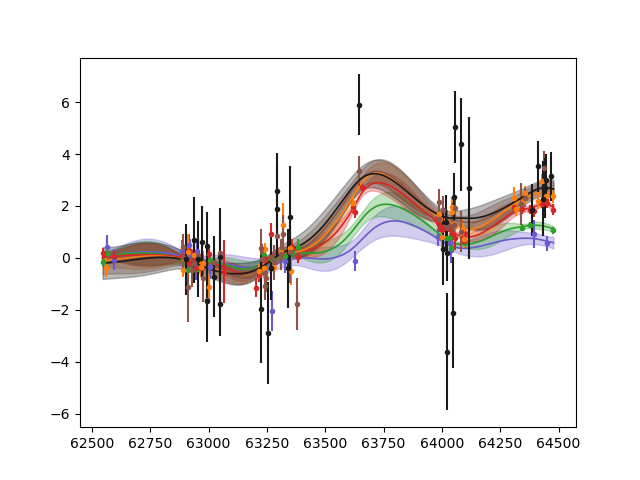

In [55]:
# Color dictionary
%matplotlib ipympl
filter_colours = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}
plt.figure()
for f in filter_wls.keys():
    df_f=df_gp[df_gp.band==f]
    plt.plot(df_f.time,df_f.flux,color=filter_colours[f],lw=1.2)
    plt.fill_between(df_f.time, df_f.flux-df_f.flux_err,df_f.flux+df_f.flux_err,alpha=.3,color=filter_colours[f])
    data=lc[lc.Filter==f]
    plt.errorbar(data['Time (MJD)'],data.Flux,data.Flux_err,color=filter_colours[f],marker=".",linestyle="")
plt.show()

In [190]:
# Plot TDE 2D GP
from matplotlib.backends.backend_pdf import PdfPages
filters=['u','g','r','i','z']#,'y']
filter_colours = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}
df_log=pd.read_csv('content/mallorn-astronomical-classification-challenge/train_log.csv')
tde=df_log[df_log.SpecType=='TDE']
with PdfPages('TDEs_2D_GP.pdf') as pdf:
    for obj_id in tde['object_id']:
        spectype=tde.loc[tde.object_id == obj_id, 'SpecType'].values[0].replace(" ", "_")
        redshift=tde.loc[tde.object_id == obj_id, 'Z'].values[0]
        split=tde.loc[tde.object_id == obj_id, 'split'].values[0]
        gp=pd.read_csv('content/mallorn-astronomical-classification-challenge/gp2d_training/{}_{}_gp2d.csv'.format(obj_id,spectype))
        peak_time=gp.time[np.argmax(gp.flux)]
        data=pd.read_csv('content/mallorn-astronomical-classification-challenge/{}/train_full_lightcurves.csv'.format(split))
        data=data[data.object_id==obj_id]
        fig1, ax = plt.subplots(ncols=1,figsize=(10,8))
        for f in filters:      
            #Selecting only the data relevant to the chosen object
            gp_band=gp[gp.band==f]
            mask=(data.Filter==f)&(data.Flux>=-1)
            data_band=data[mask]
            #Plot 2D GP light curve
            #fig1.tight_layout()
            #Plotting observed r band data & GP fit of that data 
            ax.errorbar(data_band['Time (MJD)']-peak_time, data_band.Flux, yerr=data_band.Flux_err, label='observed {}'.format(f), color=filter_colours[f], fmt='o')
            ax.plot(gp_band.time-peak_time, gp_band.flux, label='GP {}'.format(f), color=filter_colours[f])
            ax.fill_between(gp_band.time-peak_time, gp_band.flux-gp_band.flux_err,gp_band.flux+gp_band.flux_err,alpha=.3,color=filter_colours[f])
            ax.set_ylabel('Flux (μJy)')
            ax.set_xlabel('$t-t_{peak}$ in GP [d]')
            ax.set_title('{}, {} (z={})'.format(obj_id,spectype,redshift))
            if spectype!='AGN':
                ax.set_xlim(-300,+300)
            ax.legend()
        pdf.savefig(fig1)
        plt.close()

In [173]:
# Plot difference in peak time
diff_r=[]
diff_g=[]
df_log=pd.read_csv('content/mallorn-astronomical-classification-challenge/train_log_updated.csv')
for obj_id in df_log['object_id']:
    spectype=df_log.loc[df_log.object_id == obj_id, 'SpecType'].values[0].replace(" ", "_")
    rpeak_orig=df_log.loc[df_log.object_id == obj_id, 'peak_time_r'].values[0]
    gpeak_orig=df_log.loc[df_log.object_id == obj_id, 'peak_time_g'].values[0]
    # load 2d gp
    df_2d=pd.read_csv('content/mallorn-astronomical-classification-challenge/gp2d_training/{}_{}_gp2d.csv'.format(obj_id,spectype))
    r=df_2d.loc[df_2d.band=='r','flux']
    rpeak_2d=df_2d.loc[np.argmax(r),'time']#.values[0]
    #rpeak_2d=df_2d['time'][np.argmax(r)].values[0]
    g=df_2d.loc[df_2d.band=='g','flux']
    gpeak_2d=df_2d.loc[np.argmax(g),'time']#.values[0]
    #gpeak_2d=df_2d['time'][np.argmax(g)].values[0]
    diff_r.append(rpeak_orig-rpeak_2d)
    diff_g.append(gpeak_orig-gpeak_2d)

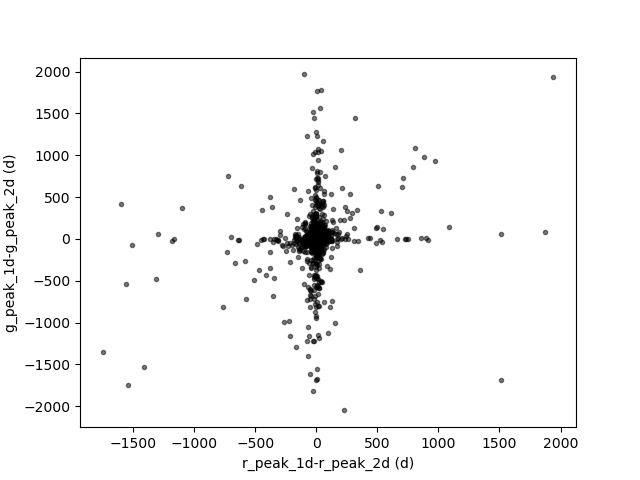

In [174]:
# GØR DET HER FOR TDE'ER !
plt.figure()
plt.plot(diff_r,diff_g,".k",alpha=.5)
plt.xlabel('r_peak_1d-r_peak_2d (d)')
plt.ylabel('g_peak_1d-g_peak_2d (d)')
plt.show()

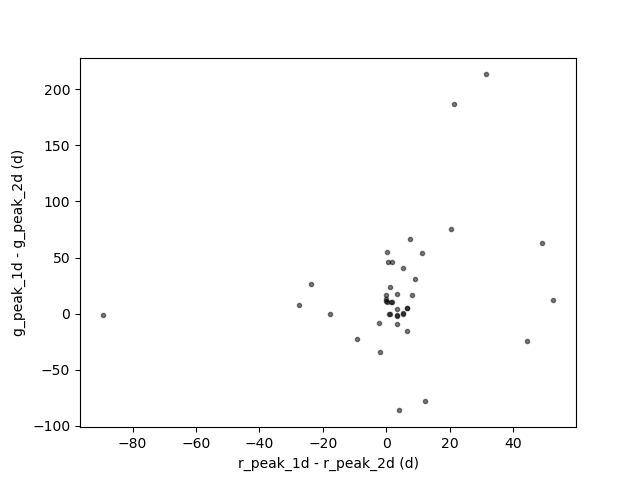

In [178]:
# for tdes only
diff_r = np.array(diff_r)
diff_g = np.array(diff_g)

idx = df_log.index[df_log['SpecType'] == 'TDE'].tolist()

plt.figure()
plt.plot(diff_r[idx], diff_g[idx], ".k", alpha=0.5)
plt.xlabel('r_peak_1d - r_peak_2d (d)')
plt.ylabel('g_peak_1d - g_peak_2d (d)')
plt.show()

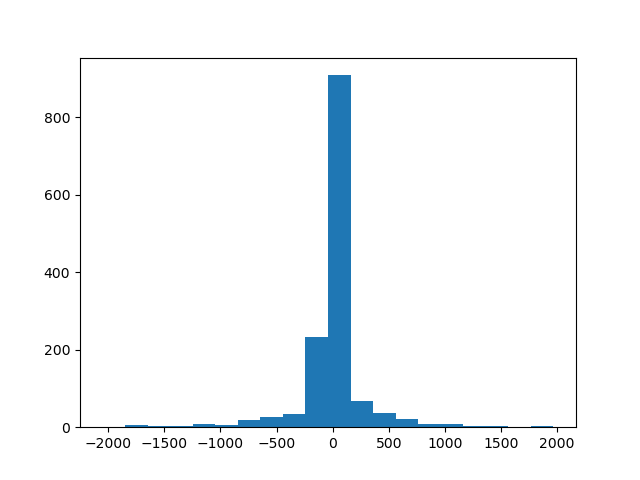

In [168]:
plt.figure()
plt.hist(diff_g,bins=20)
plt.show()

## Extract features


In [101]:
# Adapted from Avocado (K. Boone 2019)
def find_time_to_fractions(fluxes, fractions, forward=True):
    """Find the time for a lightcurve to decline to specific fractions of
    maximum light.

    Parameters
    ----------
    fluxes : numpy.array
        A list of GP-predicted fluxes at 1 day intervals.
    fractions : list
        A decreasing list of the fractions of maximum light that will be found
        (eg: [0.8, 0.5, 0.2]).
    forward : bool
        If True (default), look forward in time. Otherwise, look backward in
        time.

    Returns
    -------
    times : numpy.array
        A list of times for the lightcurve to decline to each of the given
        fractions of maximum light.
    """
    max_time = np.argmax(fluxes.values)
    max_flux = fluxes.iloc[max_time]

    result = np.zeros(len(fractions))
    result[:] = np.nan

    frac_idx = 0

    # Start at maximum light, and move along the spectrum. Whenever we cross
    # one threshold, we add it to the list and keep going. If we hit the end of
    # the array without crossing the threshold, we return a large number for
    # that time.
    offset = 0
    while True:
        offset += 1
        if forward:
            new_time = max_time + offset
            if new_time >= fluxes.shape:
                break
        else:
            new_time = max_time - offset
            if new_time < 0:
                break

        test_flux = fluxes.iloc[new_time]
        while test_flux < max_flux * fractions[frac_idx]:
            result[frac_idx] = offset
            frac_idx += 1
            if frac_idx == len(fractions):
                break

        if frac_idx == len(fractions):
            break

    return result


In [112]:
# Adapted from Avocado (K. Boone 2019)
def feature_extract(gp_observations,gp_lc):
    features = dict()
    bands=['u','g','r','i','z','y']
    # Input - df with observations, df with gp
    times = gp_observations["Time (MJD)"]
    max_times=[]
    fluxes = gp_observations["Flux"]
    flux_errors = gp_observations["Flux_err"]
    bands = gp_observations["Filter"]
    s2ns = fluxes / flux_errors
    for band in bands:
        mask=bands==band
        try:
            times_band=times[mask]
            fluxes_band=fluxes[mask]
            max_time_band=times_band[np.argmax(fluxes_band)]
            max_times.append(max_time_band)
        except:
            continue
    med_max_time=np.median(max_times)


    # Count how many observations there are
    features["count"] = len(fluxes)

    # Features from GP fit parameters # UNAVAILABLE FOR NOW!
     #for i, fit_parameter in enumerate(gp_fit_parameters):
        #features["gp_fit_%d" % i] = fit_parameter
    gp_fluxes=gp_lc['flux']
    gp_times=gp_lc['time']
    gp_start_time=min(gp_lc['time'])
    # Maximum fluxes and times. ignore times for now
    #max_times = gp_start_time + np.argmax(gp_fluxes, axis=1)
    #med_max_time = np.median(max_times)
    #max_dts = max_times - med_max_time
    #max_fluxes = np.array(
     #   [
      #      gp_fluxes[band_idx, time - gp_start_time]
       #     for band_idx, time in enumerate(max_times)
       # ]
    #)
    #features["max_time"] = med_max_time
    #for band, max_flux, max_dt in zip(plasticc_bands, max_fluxes, max_dts):
    for band in bands:
        flux_band=gp_lc.loc[gp_lc.band==band,'flux']
        max_flux=max(flux_band)
        min_flux=min(flux_band)
        features["max_flux_%s" % band] = max_flux
        features["min_flux_%s" % band] = min_flux
        #features["max_dt_%s" % band] = max_dt
        # Calculate the positive and negative integrals of the lightcurve,
        # normalized to the respective peak fluxes. This gives a measure of the
        # "width" of the lightcurve, even for non-bursty objects.
        positive_widths = np.sum(np.clip(flux_band, 0, None)) / max_flux
        negative_widths = np.sum(np.clip(flux_band, None, 0)) / min_flux
        features["positive_width_%s" % band] = positive_widths
        features["negative_width_%s" % band] = negative_widths
        # Calculate the total absolute differences of the lightcurve. For
        # supernovae, they typically go up and down a single time. Periodic
        # objects will have many more ups and downs.
        abs_diffs = np.sum(np.abs(flux_band[1:] - flux_band[:-1]))
        features["abs_diff_%s" % band] = abs_diffs
        # Find times to fractions of the peak amplitude
        fractions = [0.8, 0.5, 0.2]
        forward_times = find_time_to_fractions(flux_band, fractions)
        backward_times = find_time_to_fractions(
        flux_band, fractions, forward=False
        )
        for fraction, forward_time, backward_time in zip(
            fractions, forward_times, backward_times
        ):
            features["time_fwd_max_%.1f_%s" % (fraction, band)] = forward_time
            features["time_bwd_max_%.1f_%s" % (fraction, band)] = backward_time
        mask = bands == band
        band_fluxes = fluxes[mask]
        band_flux_errors = flux_errors[mask]
        # Sum up the total signal-to-noise in each band
        total_band_s2n = np.sqrt(np.sum((band_fluxes / band_flux_errors) ** 2))
        features["total_s2n_%s" % band] = total_band_s2n

        # Calculate percentiles of the data in each band.
        for percentile in (10, 30, 50, 70, 90):
            try:
                val = np.percentile(band_fluxes, percentile)
            except IndexError:
                val = np.nan
            features["percentile_%s_%d" % (band, percentile)] = val
        # Do peak detection on the GP output
        for positive in (True, False):
            if positive:
                band_flux=flux_band
                base_name = "peaks_pos_%s" % band
            else:
                band_flux = -flux_band
                base_name = "peaks_neg_%s" % band
            peaks, properties = find_peaks(
            band_flux, height=np.max(np.abs(band_flux) / 5.0)
            )
            num_peaks = len(peaks)

            features["%s_count" % base_name] = num_peaks

            sort_heights = np.sort(properties["peak_heights"])[::-1]
            # Measure the fractional height of the other peaks.
            for i in range(1, 3):
                if num_peaks > i:
                    rel_height = sort_heights[i] / sort_heights[0]
                else:
                    rel_height = np.nan
                features["%s_frac_%d" % (base_name, (i + 1))] = rel_height
    # Count the number of data points with significant positive/negative
    # fluxes
    thresholds = [-20, -10, -5, -3, 3, 5, 10, 20]
    for threshold in thresholds:
        if threshold < 0:
            count = np.sum(s2ns < threshold)
        else:
            count = np.sum(s2ns > threshold)
        features["count_s2n_%d" % threshold] = count
    # Count the fraction of data points that are "background", i.e. less
    # than a 3 sigma detection of something.
    features["frac_background"] = np.sum(np.abs(s2ns) < 3) / len(s2ns)
    # Count the time delay between the first and last significant fluxes
    thresholds = [5, 10, 20]
    for threshold in thresholds:
        significant_times = times[np.abs(s2ns) > threshold]
        if len(significant_times) < 2:
            dt = -1
        else:
            dt = np.max(significant_times) - np.min(significant_times)
        features["time_width_s2n_%d" % threshold] = dt
    time_bins = [
            (-5, 5, "center"),
            (-20, -5, "rise_20"),
            (-50, -20, "rise_50"),
            (-100, -50, "rise_100"),
            (-200, -100, "rise_200"),
            (-300, -200, "rise_300"),
            (-400, -300, "rise_400"),
            (-500, -400, "rise_500"),
            (-600, -500, "rise_600"),
            (-700, -600, "rise_700"),
            (-800, -700, "rise_800"),
            (5, 20, "fall_20"),
            (20, 50, "fall_50"),
            (50, 100, "fall_100"),
            (100, 200, "fall_200"),
            (200, 300, "fall_300"),
            (300, 400, "fall_400"),
            (400, 500, "fall_500"),
            (500, 600, "fall_600"),
            (600, 700, "fall_700"),
            (700, 800, "fall_800"),
        ]
    diff_times = times - med_max_time
    for start, end, label in time_bins:
        scale_gp_fluxes=[]
        mask = (diff_times > start) & (diff_times < end)
    
        # Count how many observations there are in the time bin
        count = np.sum(mask)
        features["count_max_%s" % label] = count
    
        if count == 0:
            bin_mean_fluxes = np.nan
            bin_std_fluxes = np.nan
        else:
            for band in bands:
                # Measure the GP flux level relative to the peak flux. We do
                # this by taking the median flux in each band and comparing it
                # to the peak flux. # sigrid comment: its mean not median ?
                bin_start = np.clip(
                    int(med_max_time + start - gp_start_time), 0, len(gp_times)
                )
                bin_end = np.clip(
                    int(med_max_time + end - gp_start_time), 0, len(gp_times)
                )
    
                if bin_start == bin_end:
                    scale_gp_fluxes = np.nan
                    bin_mean_fluxes = np.nan
                    bin_std_fluxes = np.nan
                else:
                    scale_gp_fluxes.append(
                        flux_band[bin_start:bin_end] / max(fluxes[bands==band])
                    )
                bin_mean_fluxes = np.mean(scale_gp_fluxes)
                bin_std_fluxes = np.std(scale_gp_fluxes)

        features["mean_max_%s" % label] = bin_mean_fluxes
        features["std_max_%s" % label] = bin_std_fluxes
    
    # Return the features.
    return features

In [ ]:
# Minimum fluxes.
   # min_fluxes = np.min(gp_fluxes, axis=1)
    #for band, min_flux in zip(plasticc_bands, min_fluxes):
     #   features["min_flux_%s" % band] = min_flux

    # Calculate the positive and negative integrals of the lightcurve,
    # normalized to the respective peak fluxes. This gives a measure of the
    # "width" of the lightcurve, even for non-bursty objects.
    #positive_widths = np.sum(np.clip(gp_fluxes, 0, None), axis=1) / max_fluxes
    #negative_widths = np.sum(np.clip(gp_fluxes, None, 0), axis=1) / min_fluxes
    #for band_idx, band_name in enumerate(plasticc_bands):
     #   features["positive_width_%s" % band_name] = positive_widths[band_idx]
      #  features["negative_width_%s" % band_name] = negative_widths[band_idx]

    # Calculate the total absolute differences of the lightcurve. For
    # supernovae, they typically go up and down a single time. Periodic
    # objects will have many more ups and downs.
    #abs_diffs = np.sum(np.abs(gp_fluxes[:, 1:] - gp_fluxes[:, :-1]), axis=1)
    #for band_idx, band_name in enumerate(plasticc_bands):
    #   features["abs_diff_%s" % band_name] = abs_diffs[band_idx]

    # Find times to fractions of the peak amplitude
    #fractions = [0.8, 0.5, 0.2]
    #for band_idx, band_name in enumerate(plasticc_bands):
        #forward_times = find_time_to_fractions(gp_fluxes[band_idx], fractions)
        #backward_times = find_time_to_fractions(
            #gp_fluxes[band_idx], fractions, forward=False
        #)
        #for fraction, forward_time, backward_time in zip(
            #fractions, forward_times, backward_times
        #):
            #features["time_fwd_max_%.1f_%s" % (fraction, band_name)] = forward_time
            #features["time_bwd_max_%.1f_%s" % (fraction, band_name)] = backward_time

        # Count the number of data points with significant positive/negative
        # fluxes
    #thresholds = [-20, -10, -5, -3, 3, 5, 10, 20]
    #for threshold in thresholds:
        #if threshold < 0:
            #count = np.sum(s2ns < threshold)
        #else:
            #count = np.sum(s2ns > threshold)
        #features["count_s2n_%d" % threshold] = count

    # Count the fraction of data points that are "background", i.e. less
    # than a 3 sigma detection of something.
    #features["frac_background"] = np.sum(np.abs(s2ns) < 3) / len(s2ns)

    #for band_idx, band_name in enumerate(plasticc_bands):
        #mask = bands == band_name
        #band_fluxes = fluxes[mask]
        #band_flux_errors = flux_errors[mask]

        # Sum up the total signal-to-noise in each band
        #total_band_s2n = np.sqrt(np.sum((band_fluxes / band_flux_errors) ** 2))
        #features["total_s2n_%s" % band_name] = total_band_s2n

        # Calculate percentiles of the data in each band.
        #for percentile in (10, 30, 50, 70, 90):
            #try:
                #val = np.percentile(band_fluxes, percentile)
            #except IndexError:
                #val = np.nan
            #features["percentile_%s_%d" % (band_name, percentile)] = val

    # Count the time delay between the first and last significant fluxes
    #thresholds = [5, 10, 20]
    #for threshold in thresholds:
        #significant_times = times[np.abs(s2ns) > threshold]
        #if len(significant_times) < 2:
            #dt = -1
        #else:
            #dt = np.max(significant_times) - np.min(significant_times)
        #features["time_width_s2n_%d" % threshold] = dt

    # Count how many data points are within a certain number of days of
    # maximum light. This provides some estimate of the robustness of the
    # determination of maximum light and rise/fall times.
    #time_bins = [
        #(-5, 5, "center"),
        #(-20, -5, "rise_20"),
        #(-50, -20, "rise_50"),
        #(-100, -50, "rise_100"),
        #(-200, -100, "rise_200"),
        #(-300, -200, "rise_300"),
        #(-400, -300, "rise_400"),
        #(-500, -400, "rise_500"),
        #(-600, -500, "rise_600"),
        #(-700, -600, "rise_700"),
        #(-800, -700, "rise_800"),
        #(5, 20, "fall_20"),
        #(20, 50, "fall_50"),
        #(50, 100, "fall_100"),
        #(100, 200, "fall_200"),
        #(200, 300, "fall_300"),
        #(300, 400, "fall_400"),
        #(400, 500, "fall_500"),
        #(500, 600, "fall_600"),
        #(600, 700, "fall_700"),
        #(700, 800, "fall_800"),
    #]
    #diff_times = times - med_max_time
    #for start, end, label in time_bins:
        #mask = (diff_times > start) & (diff_times < end)

        # Count how many observations there are in the time bin
        #count = np.sum(mask)
        #features["count_max_%s" % label] = count

        #if count == 0:
            #bin_mean_fluxes = np.nan
            #bin_std_fluxes = np.nan
        #else:
            # Measure the GP flux level relative to the peak flux. We do
            # this by taking the median flux in each band and comparing it
            # to the peak flux.
            #bin_start = np.clip(
                #int(med_max_time + start - gp_start_time), 0, len(gp_times)
            #)
            #bin_end = np.clip(
                #int(med_max_time + end - gp_start_time), 0, len(gp_times)
            #)

            #if bin_start == bin_end:
                #scale_gp_fluxes = np.nan
                #bin_mean_fluxes = np.nan
                #bin_std_fluxes = np.nan
            #else:
                #scale_gp_fluxes = (
                    #gp_fluxes[:, bin_start:bin_end] / max_fluxes[:, None]
                #)
                #bin_mean_fluxes = np.mean(scale_gp_fluxes)
                #bin_std_fluxes = np.std(scale_gp_fluxes)

        #features["mean_max_%s" % label] = bin_mean_fluxes
        #features["std_max_%s" % label] = bin_std_fluxes

    # Do peak detection on the GP output
    #for positive in (True, False):
        #for band_idx, band_name in enumerate(plasticc_bands):
            #if positive:
                #band_flux = gp_fluxes[band_idx]
                #base_name = "peaks_pos_%s" % band_name
            #else:
                #band_flux = -gp_fluxes[band_idx]
                #base_name = "peaks_neg_%s" % band_name
            #peaks, properties = find_peaks(
                #band_flux, height=np.max(np.abs(band_flux) / 5.0)
            #)
            #num_peaks = len(peaks)

            #features["%s_count" % base_name] = num_peaks

            #sort_heights = np.sort(properties["peak_heights"])[::-1]
            # Measure the fractional height of the other peaks.
            #for i in range(1, 3):
                #if num_peaks > i:
                    #rel_height = sort_heights[i] / sort_heights[0]
                #else:
                    #rel_height = np.nan
                #features["%s_frac_%d" % (base_name, (i + 1))] = rel_height

   # if return_model:
    #     Return the GP predictions along with the features.
     #   model = {}
      #  for idx, band in enumerate(plasticc_bands):
       #     model["%s" % band] = gp_fluxes[idx]
        #model["time"] = gp_times
        #model = pd.DataFrame(model).set_index("time")

        #return features, model
    #else:
        # Only return the features.
     #   return features

In [124]:
# Feature extraction, save as csv
df_log = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/test_log.csv'
)

feature_rows = []  # list of dicts

for obj_id in df_log['object_id']:
    #spectype = (
     #   df_log.loc[df_log.object_id == obj_id, 'SpecType']
      #  .values[0]
       # .replace(" ", "_")
    #)
    split = df_log.loc[df_log.object_id == obj_id, 'split'].values[0]

    # Load observations
    df_obs = pd.read_csv(
        f'content/mallorn-astronomical-classification-challenge/{split}/test_full_lightcurves.csv'
    )
    df_obs_obj = df_obs[df_obs.object_id == obj_id]

    # Load 2D GP
    df_2d = pd.read_csv(
        f'content/mallorn-astronomical-classification-challenge/gp2d_test/{obj_id}_gp2d.csv'
    )

    features = feature_extract(df_obs_obj, df_2d)
    features['object_id'] = obj_id  # key for merge

    feature_rows.append(features)
df_features = pd.DataFrame(feature_rows)

df_log = df_log.merge(df_features, on='object_id', how='left')

/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount

In [126]:
df_log.to_csv('content/mallorn-astronomical-classification-challenge/test_log_plasticc.csv')

In [274]:
# Add absolute magnitudes - without K-corrections for now

#Define a function to convert from flux in microjanskys to AB magnitude
def uJy_to_ab (mJy):
    flux_Jy = mJy/1000000
    ab = 2.5*(23 - np.log10(flux_Jy))-48.6
    return ab


def get_abs_mag(gp_lc,phases,redshift):
    """ Inputs: 
    gp_lc: DF with GP LC and redshift for object
    phases: list/array of phases (days relative to peak flux) at which to evaluate 
    redshift: redshift of object (from log)
    """

    # Filters
    bands=['u','g','r','i','z','y']
    magnitudes=dict()
    
    # Constants
    H0 = 70   # km/s/Mpc
    c = 3e5   # km/s

    # Absolute magnitude in given filter
    v = redshift * c
    dpc = v / H0 * 1e6

    # Data
    time=gp_lc['time']
    flux=gp_lc['flux']
    peak_time=time[np.argmax(flux)]
    time_shifted=time-peak_time
    band=gp_lc['band']
        
    for b in bands:
        band_flux=flux[band==b]
        for phase in phases:
            try:
                band_flux_phase=band_flux[np.rint(time_shifted)==phase]
                absmag = uJy_to_ab(np.max(band_flux_phase)) - 5 * np.log10(dpc) + 5
                magnitudes['M_{}_{}d'.format(b,phase)]=absmag
            except Exception:
                magnitudes['M_{}_{}d'.format(b,phase)]=np.nan 
    return magnitudes            
    


In [360]:
# Get equivalent of i-y r-i for 2D
df_log = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/train_log.csv'
)

color_rows = []  # list of dicts

for obj_id in df_log['object_id']:
    spectype = (
        df_log.loc[df_log.object_id == obj_id, 'SpecType']
        .values[0]
        .replace(" ", "_")
    )
    split = df_log.loc[df_log.object_id == obj_id, 'split'].values[0]
    redshift = df_log.loc[df_log.object_id == obj_id, 'Z'].values[0]

    # Load 2D GP
    df_2d = pd.read_csv(
        f'content/mallorn-astronomical-classification-challenge/gp2d_training/{obj_id}_{spectype}_gp2d.csv'
    )

    color=dict()

    # i-y
    try:
        iband=df_2d[df_2d.band=='i']
        yband=df_2d[df_2d.band=='y']
        color['i-y_new']=uJy_to_ab(max(iband.flux))-uJy_to_ab(max(yband.flux))
    except Exception:
        color['i-y_new']=np.nan

    # r-i
    try:
        rband=df_2d[df_2d.band=='r']
        iband=df_2d[df_2d.band=='i']
        color['r-i_new']=uJy_to_ab(max(rband.flux))-uJy_to_ab(max(iband.flux))
    except Exception:
        color['r-i_new']=np.nan
    
    color_rows.append(color)
df_color=pd.DataFrame(color_rows)
df_mag = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/train_mag.csv'
)


/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6
/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6


In [361]:
df_mag[df_color.columns]=df_color.values
df_mag = df_mag[df_mag.columns.drop(list(df_mag.filter(regex='Unnamed')))]
df_mag.to_csv('content/mallorn-astronomical-classification-challenge/train_mag.csv')

In [279]:
# Test!
phases=[-10,0,10,20,30,40]
df_log = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/test_log.csv'
)

mag_rows = []  # list of dicts

for obj_id in df_log['object_id']:
   # spectype = (
    #    df_log.loc[df_log.object_id == obj_id, 'SpecType']
     #   .values[0]
      #  .replace(" ", "_")
    #)
    split = df_log.loc[df_log.object_id == obj_id, 'split'].values[0]
    redshift = df_log.loc[df_log.object_id == obj_id, 'Z'].values[0]

    # Load 2D GP
    df_2d = pd.read_csv(
        f'content/mallorn-astronomical-classification-challenge/gp2d_test/{obj_id}_gp2d.csv'
    )

    features = get_abs_mag(df_2d, phases,redshift)
    features['object_id'] = obj_id  # key for merge

    mag_rows.append(features)
df_mag = pd.DataFrame(mag_rows)

/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6
/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6
/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6
/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6
/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.5*(23 - np.log10(flux_Jy))-48.6
/var/folders/z1/c7w4xcjn3c7479pfs85459zc0000z9/T/ipykernel_5969/234634894.py:6: RuntimeWarning: invalid value encountered in log10
  ab = 2.

In [281]:
df_mag.to_csv('content/mallorn-astronomical-classification-challenge/test_mag.csv')

## KEY: CatBoost classifier section

In [128]:
# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [740]:
# Try out classification - load and add new features
df_log = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/train_log_plasticc.csv'
)
df_test = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/test_log_plasticc.csv'
)
df_log = df_log[df_log.columns.drop(list(df_log.filter(regex='Unnamed')))]
mask=['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'object_id','Z_err','EBV','SpecType','English Translation','split','target','t_nan','t_nan_new','temp_peak','temp_peakerr','temp_20d','temp_20derr','peak_time_u','peak_time_g','peak_time_r','peak_time_i','peak_time_z','peak_time_y']

# Add "old" features

# Load old log - training
df_log_old = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/train_log_updated.csv'
)
df_log_old['r_grad_1030']=(df_log_old['R_eb_30.0']-df_log_old['R_eb_10.0'])/20

# Load old log - test
df_test_old = pd.read_csv(
    'content/mallorn-astronomical-classification-challenge/test_log_updated.csv'
)
df_test_old['r_grad_1030']=(df_test_old['R_eb_30.0']-df_test_old['R_eb_10.0'])/20

# order for 0.7236!!
#cols_old=['redchisq_salt2','T_eb_30.0','r_grad_1030','ESN','T_eb_15.0','g-r_eb_30.0','c_salt2','x1_salt2','r-i','Rerr_eb_30.0','Rerr_eb_20.0','i-y']#,'M_u','M_g','M_r','M_i','M_y']

# Remove r-i and i-y to avoid potential features impossible to reproduce ? 1D GP 
# cols for 0.7328, 0.7338!
cols_old=['redchisq_salt2','T_eb_30.0','r_grad_1030','ESN','T_eb_15.0','g-r_eb_30.0','c_salt2','x1_salt2','Rerr_eb_30.0','Rerr_eb_20.0','T_eb_0.0','T_eb_5.0']#,'r-i','i-y']

# not good results from this
#cols_old=['npeak_r','R_eb_40.0','Rerr_eb_40.0','redchisq_salt2','T_eb_30.0','r_grad_1030','ESN','T_eb_15.0','g-r_eb_30.0','c_salt2','x1_salt2','Rerr_eb_30.0','Rerr_eb_20.0','T_eb_0.0','T_eb_5.0']#,'r-i','i-y']


df_log[cols_old]=df_log_old[cols_old]
df_test[cols_old]=df_test_old[cols_old]

# Add abs mag features - color 
df_mag_train=pd.read_csv('content/mallorn-astronomical-classification-challenge/train_mag.csv')
df_mag_test=pd.read_csv('content/mallorn-astronomical-classification-challenge/test_mag.csv')
# Add some color columns

# phase 0
df_mag_train['u-g_0d']=df_mag_train['M_u_0d']-df_mag_train['M_g_0d']
df_mag_train['g-r_0d']=df_mag_train['M_g_0d']-df_mag_train['M_r_0d']
df_mag_train['r-i_0d']=df_mag_train['M_r_0d']-df_mag_train['M_i_0d']
df_mag_train['i-y_0d']=df_mag_train['M_i_0d']-df_mag_train['M_y_0d']
# phase 40
df_mag_train['u-g_40d']=df_mag_train['M_u_40d']-df_mag_train['M_g_40d']
df_mag_train['g-r_40d']=df_mag_train['M_g_40d']-df_mag_train['M_r_40d']
df_mag_train['r-i_40d']=df_mag_train['M_r_40d']-df_mag_train['M_i_40d']
df_mag_train['i-y_40d']=df_mag_train['M_i_40d']-df_mag_train['M_y_40d']


#phase 0
df_mag_test['u-g_0d']=df_mag_test['M_u_0d']-df_mag_test['M_g_0d']
df_mag_test['g-r_0d']=df_mag_test['M_g_0d']-df_mag_test['M_r_0d']
df_mag_test['r-i_0d']=df_mag_test['M_r_0d']-df_mag_test['M_i_0d']
df_mag_test['i-y_0d']=df_mag_test['M_i_0d']-df_mag_test['M_y_0d']

# phase 40
df_mag_test['u-g_40d']=df_mag_test['M_u_40d']-df_mag_test['M_g_40d']
df_mag_test['g-r_40d']=df_mag_test['M_g_40d']-df_mag_test['M_r_40d']
df_mag_test['r-i_40d']=df_mag_test['M_r_40d']-df_mag_test['M_i_40d']
df_mag_test['i-y_40d']=df_mag_test['M_i_40d']-df_mag_test['M_y_40d']

cols_mag=['u-g_0d','g-r_0d','r-i_0d','i-y_0d','u-g_40d','g-r_40d','r-i_40d','i-y_40d','i-y_new','r-i_new']
df_log[cols_mag]=df_mag_train[cols_mag]
df_test[cols_mag]=df_mag_test[cols_mag]

# Filter out "bad" TDE's
#bad_tdes=['hervess_hend_lam','gaurwaith_tamin_ungol','gwarth_bellas_glamor','melethron_graw_imrath','fuin_ryn_amdir','bregedur_rom_rochben','nell_tinuviel_adel','thangail_galadh_rodwen','bass_archam_rhosc']

#df_log=df_log[~df_log.object_id.isin(bad_tdes)]
print(len(df_log))

# All possible feature columns
features_all=[col for col in list(df_log) if col not in mask]
feature_cols=features_all

train=df_log.copy()

# Define float32 limits
f32_max = np.finfo(np.float32).max
f32_min = np.finfo(np.float32).min

# Replace infinities
train.replace([np.inf, -np.inf,np.nan], -99, inplace=True)

# Select numeric columns safely
numeric_cols = train.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 0:
    # Clip only numeric columns
    train.loc[:, numeric_cols] = train.loc[:, numeric_cols].clip(lower=f32_min, upper=f32_max)
else:
    print("⚠️ No numeric columns found to clip — skipping.")
train_clean = train.dropna(subset=feature_cols + ['target'])

test = df_test.copy()

# Replace NaN and infinities first
test.replace([np.inf, -np.inf, np.nan], -99, inplace=True)



# Select numeric columns safely
numeric_cols = test.select_dtypes(include=[np.number]).columns
 #   print("⚠️ No numeric columns found to clip — skipping.")
if len(numeric_cols) > 0:
    # Clip only numeric columns
    test.loc[:, numeric_cols] = test.loc[:, numeric_cols].clip(lower=f32_min, upper=f32_max)
else:
    print("⚠️ No numeric columns found to clip — skipping.")



# Features (X) and labels (y) (when using train data for testing)
X = train_clean[feature_cols]
y = train_clean['target']
#print(len(train_clean))

# When using test data for testing :)

#X_val=test[feature_cols]



# Split training data to have initial test data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=280, stratify=y
)
print(len(feature_cols))

3043
237


## CatBoost
The hyperparameters have not been changed much. I mainly tried different learning rates and found 0.07 to perform well.

In [785]:
# Try out different random seeds 
from sklearn.model_selection import TunedThresholdClassifierCV
X_train = train_clean[feature_cols]
y_train = train_clean['target']

X_val=test[feature_cols]

clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.07,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train)-sum(y_train))/sum(y_train)],  # [weight_negative, weight_positive]
    random_seed=251,
    verbose=False
)

clf.fit(X_train, y_train)

tuned_model=TunedThresholdClassifierCV(clf,scoring='f1',cv=5).fit(X_train,y_train)
print(f"Cut-off at {tuned_model.best_threshold_:.3f}")
ypred=tuned_model.predict(X_val)
print(len(ypred[ypred==1]))

Cut-off at 0.363
432


In [786]:
# maybes: 103 (467 tdes, low-ish cv), 104 (405, low-ish), 112 (481, 0.65). 114!! -> 0.7201 120 (508)
# maybes for real (237 feats): 8 (474, 0.66), 24 (488, 0.666) 29 (419, 0.662) 251 (458, 0.66) 291 (409,0.65?) 301 (432, 0.644 ->0.7286) 304 (459, 0.667 -> 0.7139)
# 307 (437, 0.63) 309 (530, 0.68)
# maybes 240 feats: 4 (447, 0.654), 6 (478, 0.663) 7 (478, 0.667) 8 (459, 0.678 -> 0.7125) 9 11 26
tuned_model.best_score_

np.float64(0.6440429924162195)

In [787]:
#Save predictions
df_test['prediction']=ypred
df_preds = df_test[['object_id', 'prediction']]
df_preds.to_csv(
    'content/mallorn-astronomical-classification-challenge/predictions.csv',
    index=False)

In [801]:
explainer = shap.TreeExplainer(clf)
shap_inter = explainer.shap_interaction_values(X_train.sample(2000))


In [802]:
# mean absolute interaction strength
inter_strength = np.abs(shap_inter).mean(axis=0)


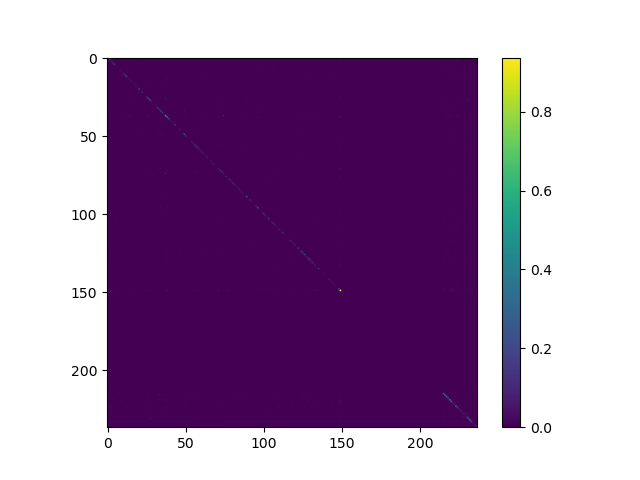

In [803]:
plt.figure()
plt.imshow(inter_strength,norm='linear')
plt.colorbar()

## KEY: Final result
Here I decide on the random seed 251 and test out methods to improve the classification threshold

In [918]:
# Same cell as above
from sklearn.model_selection import TunedThresholdClassifierCV
X_train = train_clean[feature_cols]
y_train = train_clean['target']

X_val=test[feature_cols]
# maybe: 27 (508,0.65)
clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.07,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train)-sum(y_train))/sum(y_train)],  # [weight_negative, weight_positive]
    random_seed=251,
    verbose=False
)

clf.fit(X_train, y_train)

tuned_model=TunedThresholdClassifierCV(clf,scoring='f1',cv=5).fit(X_train,y_train)
print(f"Cut-off at {tuned_model.best_threshold_:.3f}")
print(tuned_model.best_score_)
ypred=tuned_model.predict(X_val)
print(len(ypred[ypred==1]))

Cut-off at 0.343
0.6602169513664593
458


In [896]:
# Get threshold from OOF rather than globally
# 0.7365!! 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=251)

def best_f1_threshold(y_true, y_prob, thresholds=np.linspace(0.05, 0.95, 181)):
    best_t, best_f1 = 0.5, 0.0
    for t in thresholds:
        f1 = f1_score(y_true, (y_prob >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1
    
fold_thresholds = []
fold_f1s = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.07,
        depth=6,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights=[1,(len(y_tr)-sum(y_tr))/sum(y_tr)],
        random_seed=251 - fold,
        verbose=False
    )

    clf.fit(X_tr, y_tr)

    va_probs = clf.predict_proba(X_va)[:, 1]
    t, f1 = best_f1_threshold(y_va, va_probs)

    fold_thresholds.append(t)
    fold_f1s.append(f1)

    print(f"Fold {fold}: best threshold={t:.3f}, F1={f1:.4f}")
# Change threshold incrementally
# I get the best public score with a threshold of np.median(fold_thresholds)+0.05
final_threshold = np.median(fold_thresholds)+0.05 #+0.02 for 0.7462 # +0.04 for 0.7506 #0.05 for 0.7525 # 0-07 for 0.7493
print("Final threshold:", final_threshold)
print("Thresholds per fold:", fold_thresholds)
final_clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.07,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train)-sum(y_train))/sum(y_train)],
    random_seed=251,
    verbose=False
)

final_clf.fit(X_train, y_train)

test_probs = final_clf.predict_proba(X_val)[:, 1]
test_preds = (test_probs >= final_threshold).astype(int)

print("Predicted positives:", test_preds.sum())


Fold 0: best threshold=0.515, F1=0.7241
Fold 1: best threshold=0.245, F1=0.8286
Fold 2: best threshold=0.415, F1=0.7536
Fold 3: best threshold=0.370, F1=0.6197
Fold 4: best threshold=0.115, F1=0.6747
Final threshold: 0.41999999999999993
Thresholds per fold: [np.float64(0.5149999999999999), np.float64(0.245), np.float64(0.4149999999999999), np.float64(0.36999999999999994), np.float64(0.11499999999999999)]
Predicted positives: 415


In [897]:
print("Global tuned threshold:", tuned_model.best_threshold_)
print("Per-fold tuned threshold:", final_threshold)


Global tuned threshold: 0.34306585852486654
Per-fold tuned threshold: 0.41999999999999993


In [895]:
#Save predictions
df_test['prediction']=test_preds
df_preds = df_test[['object_id', 'prediction']]
df_preds.to_csv(
    'content/mallorn-astronomical-classification-challenge/predictions.csv',
    index=False)

## Feature importances - SHAP and mean decrease in impurity

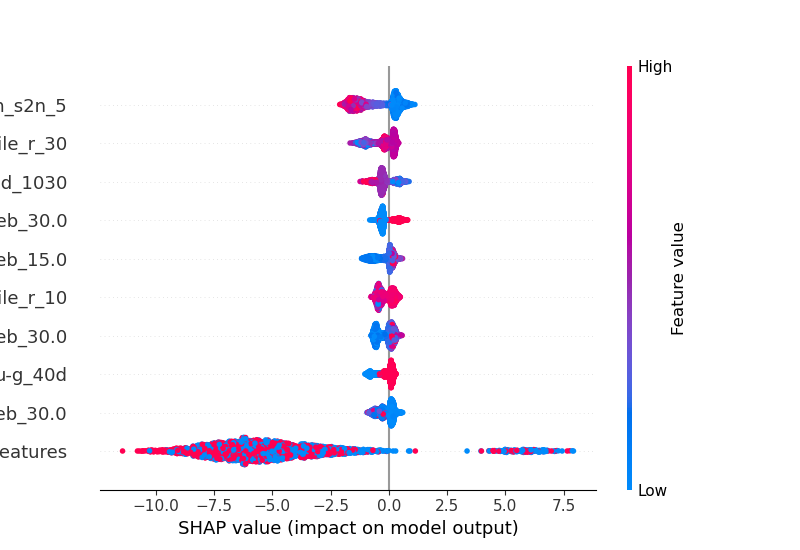

In [916]:
import shap
explainer = shap.Explainer(final_clf)
shap_values = explainer(X_train)
# summarize the effects of all the features
plt.close('all')
plt.figure(figsize=(10,6))
n=10
shap.plots.beeswarm(shap_values,max_display=n) # 
plt.savefig(
    f'final_result_top{n}_feat_SHAP.pdf',
    bbox_inches="tight"
)

In [903]:
# Print top 20 features according to SHAP

# Mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Create a ranked feature list
feature_importance = pd.Series(
    mean_abs_shap,
    index=X_train.columns
).sort_values(ascending=False)

# Select top features
n=20
top_features = feature_importance.head(n).index.tolist()
print(top_features)

['time_width_s2n_5', 'percentile_r_30', 'r_grad_1030', 'g-r_eb_30.0', 'T_eb_15.0', 'percentile_r_10', 'T_eb_30.0', 'u-g_40d', 'Rerr_eb_30.0', 'peaks_pos_z_frac_2', 'time_fwd_max_0.2_g', 'Z', 'redchisq_salt2', 'count', 'Rerr_eb_20.0', 'min_flux_r', 'time_bwd_max_0.2_y', 'min_flux_y', 'percentile_r_50', 'positive_width_r']


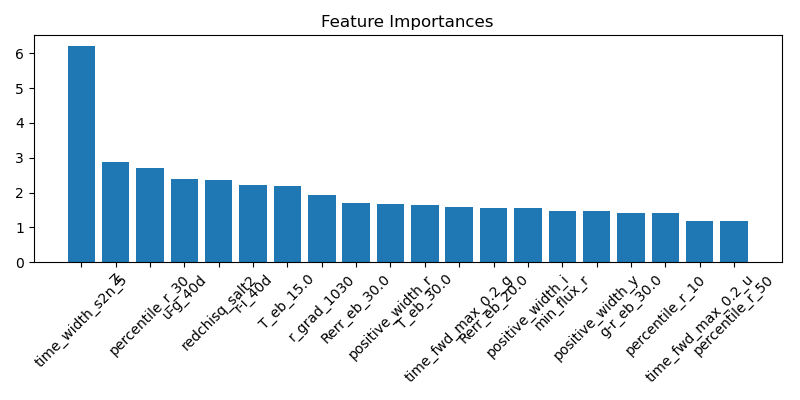

In [917]:
# Mean decrease in impurity
importances = final_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices_subset=indices[:20]

plt.figure(figsize=(8,4))
plt.bar(range(len(indices_subset)), importances[indices_subset], align='center')
plt.xticks(range(len(indices_subset)), np.array(feature_cols)[indices_subset], rotation=45)
plt.title("Feature Importances")
plt.tight_layout()
plt.savefig('final_result_top20_feat_impurity_decrease.pdf')
plt.show()